In [2]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

snapshot_array = pickle.load( open( "snapshot/np_128square_without_label.pickle", "rb" ) )
snapshot_array=snapshot_array/255.

# n_image_row=3
# n_image_col=3
# total_image=n_image_row*n_image_col
# image_index=random.sample(list(range(snapshot_array.shape[0])),total_image)
# for i,k in enumerate(image_index):
#     plt.subplot(n_image_row,n_image_col,i+1)
#     plt.imshow(snapshot_array[k])

from sklearn.utils import shuffle
snapshot_array=shuffle(snapshot_array)
training_ratio=0.7
training_cut=int(training_ratio*snapshot_array.shape[0])
X_train=snapshot_array[:training_cut,]
X_test=snapshot_array[-1000:,]

del snapshot_array

def convpool(X,W,b):
    conv_out=tf.nn.conv2d(X,W,strides=[1,1,1,1],padding="SAME")
    conv_out=tf.nn.bias_add(conv_out,b)
    conv_out=tf.nn.elu(conv_out)
    pool_out=tf.nn.max_pool(conv_out,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    return pool_out

def init_filter(shape,poolsz):
    w=np.random.randn(*shape)/np.sqrt(np.prod(shape[:-1])+shape[-1]*np.prod(shape[:-2]/np.prod(poolsz)))
    return w.astype(np.float32)

from functools import partial
he_init = tf.contrib.layers.variance_scaling_initializer(mode="FAN_AVG") # he init method
scale=0.0
my_dense=partial(tf.layers.dense,activation=tf.nn.elu,
                 kernel_regularizer=tf.contrib.layers.l1_regularizer(scale),
                 kernel_initializer=he_init)


INFO:tensorflow:Scale of 0 disables regularizer.


In [16]:
checkpoints_savepath="model_checkpoints_large/CAE_04302018_2_smaller.ckpt"
n_epochs=50
N=X_train.shape[0]
batch_size=500
n_batches=N//batch_size
pool_sz=(2,2)

learning_rate=0.01
tf.reset_default_graph()
# cnn_pool layer 1
W1_shape=(2,2,3,6)
W1_init=init_filter(W1_shape,pool_sz)
b1_init=np.zeros(W1_shape[-1],dtype=np.float32)

# cnn_pool layer 2
W2_shape=(2,2,6,12)
W2_init=init_filter(W2_shape,pool_sz)
b2_init=np.zeros(W2_shape[-1],dtype=np.float32)

# cnn_pool layer 2
W3_shape=(3,3,12,24)
W3_init=init_filter(W3_shape,pool_sz)
b3_init=np.zeros(W3_shape[-1],dtype=np.float32)

X=tf.placeholder(tf.float32,shape=(None,128,128,3),name="X")

with tf.name_scope("cnn"):
    with tf.device("/gpu:0"):
        W1=tf.Variable(W1_init.astype(np.float32))
        b1=tf.Variable(b1_init.astype(np.float32))
        W2=tf.Variable(W2_init.astype(np.float32))
        b2=tf.Variable(b2_init.astype(np.float32))
        W3=tf.Variable(W3_init.astype(np.float32))
        b3=tf.Variable(b3_init.astype(np.float32))
        Z1=convpool(X,W1,b1)
        Z2=convpool(Z1,W2,b2)
        Z3=convpool(Z2,W3,b3)
    with tf.device("/gpu:1"):
        Z4=tf.layers.conv2d_transpose(Z3,filters=12,kernel_size=(3,3),strides=(2, 2),
                                      padding='same',activation=tf.nn.elu)
        Z5=tf.layers.conv2d_transpose(Z4,filters=6,kernel_size=(2,2),strides=(2, 2),
                                      padding='same',activation=tf.nn.elu)
        Z6=tf.layers.conv2d_transpose(Z5,filters=3,kernel_size=(2,2),strides=(2, 2),
                                      padding='same',activation=tf.nn.elu)
        reconstruction=Z6

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.squared_difference(reconstruction, X))

with tf.name_scope("train"):
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op=optimizer.minimize(loss)
with tf.name_scope("saver"):
    saver = tf.train.Saver()
    

training the network

In [42]:
init=tf.global_variables_initializer()
train_mse_save=[]
test_mse_save=[]
with tf.Session() as sess:
    init.run()
    try:
        saver.restore(sess, checkpoints_savepath)
    except:
        print("restoring error, will start over!")
    for epoch in range(1,n_epochs+1):
        X_train=shuffle(X_train)
        for batch in range(n_batches):
            X_batch=X_train[batch*batch_size:batch*batch_size+batch_size,]
            sess.run(training_op,feed_dict={X:X_batch})
            training_loss=loss.eval(feed_dict={X:X_batch})
            testing_loss=loss.eval(feed_dict={X:X_test})
        print("epoch {:3d} MSE(training_batch) {:7.6f} MSE(testing) {:7.6f}".\
              format(epoch,training_loss,testing_loss),end="\r")
        train_mse_save.append(training_loss)
        test_mse_save.append(testing_loss)
        if epoch % 10==0:
            save_path=saver.save(sess,checkpoints_savepath)

INFO:tensorflow:Restoring parameters from model_checkpoints_large/CAE_04302018_2_smaller.ckpt


testing the output

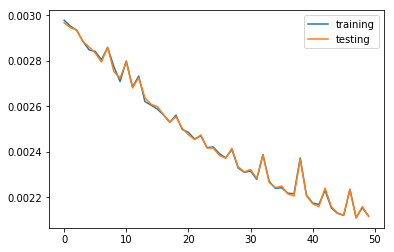

In [43]:
line_train,=plt.plot(train_mse_save,label="training")
line_test,=plt.plot(test_mse_save,label="testing")
plt.legend(handles=[line_train, line_test])

visualize the reconstruction

INFO:tensorflow:Restoring parameters from model_checkpoints_large/CAE_04302018_2_smaller.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


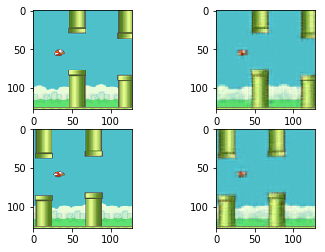

In [45]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, checkpoints_savepath)
    n_image_row=2
    n_image_col=2
    total_image=n_image_row*n_image_col
    image_index=random.sample(list(range(X_test.shape[0])),n_image_row)
    for i,k in enumerate(image_index):
        plt.subplot(n_image_row,n_image_col,i*n_image_col+1)
        plt.imshow(X_test[k])
        plt.subplot(n_image_row,n_image_col,i*n_image_col+2)
        reconstructed_image=reconstruction.eval(feed_dict={X:[X_test[k]]})
        plt.imshow(reconstructed_image[0])

visualize the output from the encoder

INFO:tensorflow:Restoring parameters from model_checkpoints_large/CAE_04302018_2_smaller.ckpt


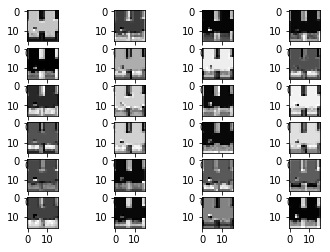

In [49]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, checkpoints_savepath)
    n_image_row=6
    n_image_col=4
    total_image=n_image_row*n_image_col
    image_index=list(range(24))
    for i,k in enumerate(image_index):
        plt.subplot(n_image_row,n_image_col,i+1)
        encoded_image=Z3.eval(feed_dict={X:[X_test[0]]})
        plt.imshow(encoded_image[0,:,:,k],cmap="gray")